# Домашнее задание № 9

### Задание 1 (5 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs.ipynb

Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую.
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [1]:
%pip install --upgrade keras
%pip install torch torchvision torchaudio
%pip install scikit-learn pandas matplotlib transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 649.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.1.1


In [3]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/My Drive")
data = pd.read_csv('/kaggle/input/lenta-sample/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [5]:
data.topic.value_counts()

topic
Из жизни             55
Бывший СССР          54
Наука и техника      54
Культура             53
Ценности             45
Дом                  45
Интернет и СМИ       44
Бизнес               44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: count, dtype: int64

In [6]:
data.shape

(607, 6)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("google-bert/bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [10]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

In [10]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [11]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [12]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [13]:
X.shape

(607, 512)

In [14]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [15]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [16]:
X

array([[  101, 74584, 14155, ...,     0,     0,     0],
       [  101, 33822, 84682, ...,     0,     0,     0],
       [  101,   309, 16904, ...,     0,     0,     0],
       ...,
       [  101, 11515,   119, ...,     0,     0,     0],
       [  101, 11515,   119, ...,     0,     0,     0],
       [  101, 11515,   119, ...,     0,     0,     0]], dtype=int32)

In [18]:
for param in model_bert.parameters():
    param.requires_grad = False

In [19]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# добавим дропаут чтобы не переобучалось
drop = keras.layers.Dropout(0.1)(output[:, 0]) # [0][:, 0] - означает что мы берем первое
                                                     # состояние у всех текстов в батче
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

# обычно при дообучении трансформеров нужно ставить очень маленький лосс
# но когда мы обучаем только итоговый классификатор то можно ставить побольше
model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [20]:
model_clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bert_wrapper (bert_wrapper)     │ (None, 512, 768)       │   177,853,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 17)             │        13,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,866,513 (678.51 MB)

 Trainable params: 13,073 (51.07 KB)

 Non-trainable params: 177,853,440 (678.46 MB)

In [21]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [23]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=20,
          epochs=20)

Epoch 1/20


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.0748 - loss: 2.8472 - rec_prec: 5.5556e-04 - val_accuracy: 0.0968 - val_loss: 2.7345 - val_rec_prec: 0.0645
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 623ms/step - accuracy: 0.0961 - loss: 2.7334 - rec_prec: 0.0000e+00 - val_accuracy: 0.1935 - val_loss: 2.6840 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 639ms/step - accuracy: 0.1026 - loss: 2.7194 - rec_prec: 0.0000e+00 - val_accuracy: 0.1290 - val_loss: 2.6676 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 664ms/step - accuracy: 0.1335 - loss: 2.6521 - rec_prec: 0.0025 - val_accuracy: 0.1935 - val_loss: 2.6464 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 694ms/step - accuracy: 0.1222 - loss: 2.6620 - rec_prec: 0.0038 - val_accuracy: 0.1935 - val_loss: 2.6414 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 676ms/step - accuracy: 0.1475 - loss: 2.6197 - rec_prec: 2.9703e-04 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


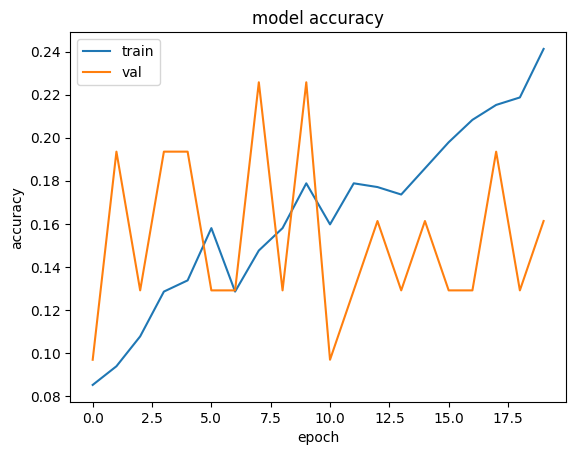

In [24]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


In [26]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
         Из жизни       0.19      1.00      0.32         3
      Бывший СССР       0.00      0.00      0.00         3
         Ценности       0.00      0.00      0.00         2
            Спорт       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00         2
              Дом       0.00      0.00      0.00         2
         Культура       1.00      0.33      0.50         3
       Библиотека       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00       

----

Итого, не то чтобы без дообучения она совсем не работала, она явно как-то работает, но очень плохо, с дообучеием ниже она начинает работать значительно лучше, хоть все еще звезд не хватает

In [22]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [23]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [25]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_197', 'variable_198'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 426ms/step - accuracy: 0.0778 - loss: 2.9194 - rec_prec: 0.0000e+00 - val_accuracy: 0.1613 - val_loss: 2.7070 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.2618 - loss: 2.3740 - rec_prec: 0.0387 - val_accuracy: 0.4194 - val_loss: 1.8744 - val_rec_prec: 0.2581
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.7115 - loss: 1.0648 - rec_prec: 0.5532 - val_accuracy: 0.5161 - val_loss: 1.6728 - val_rec_prec: 0.1935
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9429 - loss: 0.2525 - rec_prec: 0.9866 - val_accuracy: 0.4839 - val_loss: 1.7646 - val_rec_prec: 0.2903
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9996 - loss: 0.0493 - rec_prec: 1.0000 - val_accuracy: 0.4839 - val_loss: 1.5219 - val_rec_prec: 0.2903
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 1.0000 - loss: 0.0113 - rec_prec: 1.0000 - val_accuracy: 0.5161 - val_l

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


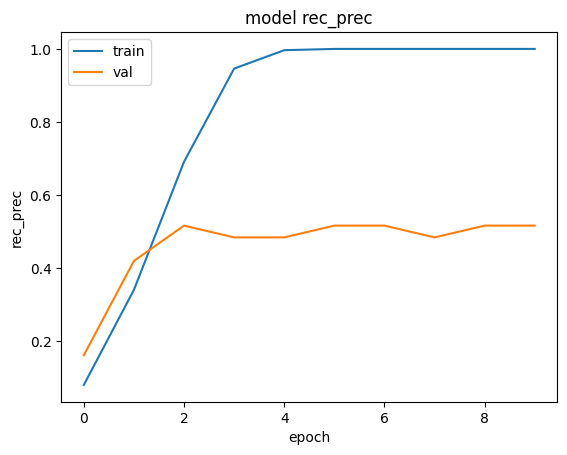

In [26]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
from sklearn.metrics import classification_report

In [30]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


In [31]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Культура       0.50      0.67      0.57         3
         Из жизни       0.67      0.67      0.67         3
              Дом       1.00      0.50      0.67         2
        Экономика       0.50      0.50      0.50         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
  Наука и техника       0.50      0.67      0.57         3
   Интернет и СМИ       0.33      0.50      0.40         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
         Ценности       0.67      1.00      0.80         2
          Легпром       0.00      0.00      0.00         1
           Россия       0.33      0.50      0.40         2
            Спорт       0.00      0.00      0.00         2
Силовые структуры       0.33      0.50      0.40         2
           Бизнес       1.00      1.00      1.00       

----

----

In [7]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")
model_bert = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
for param in model_bert.parameters():
    param.requires_grad = False

In [19]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

In [18]:
X.shape

(607, 512)

In [20]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# добавим дропаут чтобы не переобучалось
drop = keras.layers.Dropout(0.1)(output[:, 0]) # [0][:, 0] - означает что мы берем первое
                                                     # состояние у всех текстов в батче
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

# обычно при дообучении трансформеров нужно ставить очень маленький лосс
# но когда мы обучаем только итоговый классификатор то можно ставить побольше
model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

RuntimeError: Exception encountered when calling bert_wrapper.call().

[1mCould not automatically infer the output shape / dtype of 'bert_wrapper_1' (of type bert_wrapper). Either the `bert_wrapper.call()` method is incorrect, or you need to implement the `bert_wrapper.compute_output_spec() / compute_output_shape()` method. Error encountered:

Exception encountered when calling TorchModuleWrapper.call().

[1mCUDA out of memory. Tried to allocate 16.76 GiB. GPU 0 has a total capacty of 14.75 GiB of which 13.45 GiB is free. Process 2178 has 1.29 GiB memory in use. Of the allocated memory 1.12 GiB is allocated by PyTorch, and 52.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF[0m

Arguments received by TorchModuleWrapper.call():
  • args=('torch.Tensor(shape=torch.Size([83, 512]), dtype=int32)',)
  • kwargs=<class 'inspect._empty'>[0m

Arguments received by bert_wrapper.call():
  • args=('<KerasTensor shape=(None, 512), dtype=int32, sparse=None, name=input_ids>',)
  • kwargs=<class 'inspect._empty'>

In [80]:
model_clf.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bert_wrapper_11 (bert_wrapper)  │ (None, 512, 312)       │    11,784,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_4 (GetItem)            │ (None, 312)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 312)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │         5,321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,789,489 (44.97 MB)

 Trainable params: 5,321 (20.79 KB)

 Non-trainable params: 11,784,168 (44.95 MB)

In [100]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [86]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=20,
          epochs=20)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [85]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys([])


KeyError: 'accuracy'

In [55]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


In [56]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
         Из жизни       0.29      0.67      0.40         3
      Бывший СССР       0.00      0.00      0.00         3
         Ценности       0.00      0.00      0.00         2
            Спорт       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00         2
              Дом       0.00      0.00      0.00         2
         Культура       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00       

Ну опять же таки не сказать что совсем не работает, она очень сомнительно опредеяет два класса)) но и модель довольно забавная, так что, может быть, даже интересно, что она хоть как-то работает и интересно, сколько прироста в таком случае дает дообучение ниже.

----

In [59]:
model = AutoModelForSeq2SeqLM.from_pretrained("IlyaGusev/rubert_telegram_headlines")

In [61]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32', name="input_ids")
output = BertWrapper(model)(inputs={'input_ids': input_word_ids})
# Добавим dropout, чтобы избежать переобучения
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)


model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

RuntimeError: Exception encountered when calling BertWrapper.call().

[1mCould not automatically infer the output shape / dtype of 'bert_wrapper_8' (of type BertWrapper). Either the `BertWrapper.call()` method is incorrect, or you need to implement the `BertWrapper.compute_output_spec() / compute_output_shape()` method. Error encountered:

Exception encountered when calling TorchModuleWrapper.call().

[1mYou have to specify either input_ids or inputs_embeds[0m

Arguments received by TorchModuleWrapper.call():
  • args=('torch.Tensor(shape=torch.Size([83, 512]), dtype=int32)',)
  • kwargs=<class 'inspect._empty'>[0m

Arguments received by BertWrapper.call():
  • args=<class 'inspect._empty'>
  • kwargs={'inputs': {'input_ids': '<KerasTensor shape=(None, 512), dtype=int32, sparse=None, name=input_ids>'}}

In [23]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [25]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_197', 'variable_198'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 426ms/step - accuracy: 0.0778 - loss: 2.9194 - rec_prec: 0.0000e+00 - val_accuracy: 0.1613 - val_loss: 2.7070 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.2618 - loss: 2.3740 - rec_prec: 0.0387 - val_accuracy: 0.4194 - val_loss: 1.8744 - val_rec_prec: 0.2581
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.7115 - loss: 1.0648 - rec_prec: 0.5532 - val_accuracy: 0.5161 - val_loss: 1.6728 - val_rec_prec: 0.1935
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9429 - loss: 0.2525 - rec_prec: 0.9866 - val_accuracy: 0.4839 - val_loss: 1.7646 - val_rec_prec: 0.2903
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9996 - loss: 0.0493 - rec_prec: 1.0000 - val_accuracy: 0.4839 - val_loss: 1.5219 - val_rec_prec: 0.2903
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 1.0000 - loss: 0.0113 - rec_prec: 1.0000 - val_accuracy: 0.5161 - val_l

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


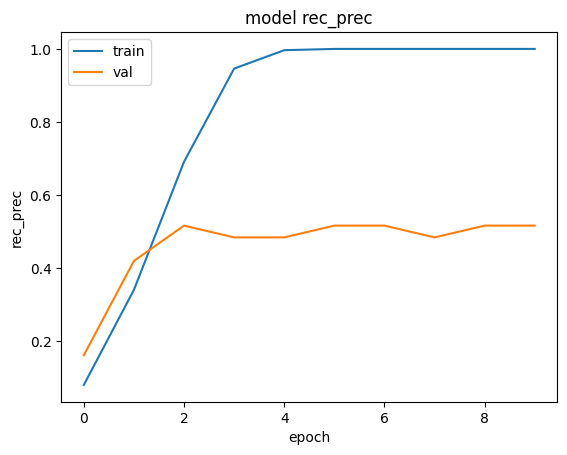

In [26]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
from sklearn.metrics import classification_report

In [30]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


In [31]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Культура       0.50      0.67      0.57         3
         Из жизни       0.67      0.67      0.67         3
              Дом       1.00      0.50      0.67         2
        Экономика       0.50      0.50      0.50         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
  Наука и техника       0.50      0.67      0.57         3
   Интернет и СМИ       0.33      0.50      0.40         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
         Ценности       0.67      1.00      0.80         2
          Легпром       0.00      0.00      0.00         1
           Россия       0.33      0.50      0.40         2
            Спорт       0.00      0.00      0.00         2
Силовые структуры       0.33      0.50      0.40         2
           Бизнес       1.00      1.00      1.00       

### Задание 2 (5 баллов).

Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/gpt/gpt.ipynb

Попробуйте дообучать GPT на каком-то другом тексте (можете попробовать любые стихи или какие-то специфичные вещи вроде анекдотов или репа).
Попробуйте разные методы и параметры генерации (beam search, температура, top_k и тп). Сохраните в тетрадке несколько хороших сгенерированных текстов.

Можете использовать другую модель.


In [1]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers.utils import logging

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
DEVICE = torch.device("cuda:0")

model_name_or_path = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path, use_cache=False).to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
text = """
Штирлиц играл в карты и проигрался. Но Штирлиц умел делать хорошую мину при плохой игре. Когда Штирлиц покинул компанию, мина сработала.

Идет Штирлиц ночью по городу, навстречу мужик бородатый и в чалме.
- Будь он не Ладен - подумал Штирлиц.

Штирлиц и Мюллер ездили по очереди на танке. Очередь редела, но не расходилась...

Штирлиц стрелял вслепую. Слепая испугалась и побежала скачками, но качки быстро отстали.

Подвыпившие Штирлиц и Мюллер вышли из бара.
- Давайте снимем девочек, - предложил Штирлиц.
- У вас очень доброе сердце - ответил Мюллер. - Но пусть все-таки повисят до утра.

Штирлиц шёл по улице, когда внезапно перед ним что-то упало. Штирлиц поднял глаза -- это были глаза профессора Плейшнера.

Штирлиц вышел из дома и увидел как четыре бугая ставили трактор на попа.
- Бедный пастор Шлаг, -- подумал Штирлиц

Штирлиц вытащил из сейфа записку Мюллера. Мюллеру было очень больно и он сильно ругался.

-- Штирлиц, вы еврей? -- спросил Мюллер.
-- Я русский, -- с достоинством сказал Штирлиц.
-- А я немецкий, -- усмехнулся Мюллер.

Кэт подошла к зеркалу и увидела на шее пятно.
"Засос", - подумала она, вспомнив, как вчера Штирлиц дал ей по шее за то, что она передала "СОС" открытым текстом.

Штирлиц упал с балкона и чудом зацепился за другой балкон. Чудо потом распухло и мешало ходить...

Штирлицу попала в голову пуля. "Разрывная," - раскинул мозгами Штирлиц.

Штирлиц стоял на своем. Это была любимая пытка Мюллера.

Штирлиц настаивал на своем. Настойка получалась крепкой, но слегка мутноватой.

Штирлицу сказали "Пошли!!"
Штирлиц послушался, и рассказал неприличный анекдот.

Штирлиц всю ночь топил камин. На утро камин утонул.

Штирлиц стоял над картой мира. Его неудержимо рвало на родину.

Штирлиц сел в свой автомобиль и сказал шоферу: "Трогай!" Шофер потрогал, Штирлиц поехал.

Штирлиц и Кэт вышли на связь. Но в центре об этом узнали только через девять месяцев.

Штирлиц долго смотрел в одну точку. Потом в другую. "Двоеточие!" - наконец-то смекнул Штирлиц.

Письмо из центра до Штиpлица не дошло... Пришлось читать во второй раз.

Штирлиц выстрелил вслепую. Слепая упала как подкошенная. Подкошенную Штирлиц застрелил накануне.

Лампа горела, но света не давала.
"Что-то тут не так ..." - подумал Штирлиц и погасил лампу.
Света дала.

Штирлиц шел по лесу и напоролся на сук. Суки разбежались.

Штирлиц сунул вилку в розетку, когда ему тактично намекнули, что из розетки едят ложечкой.

Во время секретного совещания в бункер Гитлера с шашкой наголо ворвался Штирлиц и закричал:
- Порублю, гады.
Гады скинулись по рублю. Штирлиц собрал деньги и ушел.

Штирлиц сидел у камина и вязал. Вязание успокаивало Штирлица. После окончания вязания у камина остался лежать связанный Мюллер.

- Штирлиц, у вас есть план? - спросил Шелленберг.
- Конечно. Но я больше люблю героин, - ответил с улыбкой Штирлиц.

Штирлиц рассказал неприличный анекдот и вогнал Мюллера в краску. "Стеснительный какой" - подумал Штирлиц, наглухо закрывая бочку.

Штирлиц спросил Кэт: - Вы любите фильмы про любовь?
- Бесспорно! - ответила Кэт.
- А я с порно, - признался Штирлиц.

Штирлиц поднял трубку и услышал томный голос радистки Кэт:
- Вам, наверное, не спится без меня?
- Почему же? Спиться я могу и без вас, - ответил Штирлиц и налил очередной стакан водки.

Штирлиц шёл в Дрезден с трудом разбирая дорогу.
Наутро железная дорога от Берлина до Дрездена была полностью разобрана...

В прошлом году Штирлицу присвоили очередное воинское звание и дали папаху.
Пах болит до сих пор ...

Штирлиц шел по лесу и увидел голубые ели! Когда он подошел поближе, то увидел, что голубые не только ели, но ещё пили, курили травку и танцевали.

Штирлиц ехал на машине по берегу моря.
'Выйду посмотрю отлив на море' - подумал Штирлиц... и отлив, посмотрел.

Штирлицу за шиворот упала гусеница. "Где-то взорвался танк," -- подумал Штирлиц.

Штирлиц приготовился к бою, ....
а пришла гёрл...

Штирлиц вышел из моря и лёг на гальку. Галька обиделась и ушла.

"""

In [5]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Сохраним обучающие данные в .txt файл 
train_path = 'train_dataset.txt'
with open(train_path, "w") as f:
    f.write(text)

# Создание датасета
train_dataset = TextDataset( tokenizer=tokenizer,file_path=train_path,block_size=64, 
                            overwrite_cache=True)
  
# специальный класс который будет подавать в модель данные в нужном ей виде
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

2024-03-25 16:09:51.531593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 16:09:51.531696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 16:09:51.691528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling

In [6]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments( 
    output_dir= "./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=100, 
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    gradient_accumulation_steps=16, 
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (torch.optim.AdamW(model.parameters(),lr=1e-5),None) # Optimizer and lr scheduler
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [7]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


TrainOutput(global_step=100, training_loss=0.07874387741088867, metrics={'train_runtime': 342.8957, 'train_samples_per_second': 5.249, 'train_steps_per_second': 0.292, 'total_flos': 58790707200000.0, 'train_loss': 0.07874387741088867, 'epoch': 100.0})

In [9]:
text = "Штирлиц работал сутками "
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        temperature=0.8,
                        top_k=50,
                        max_length=30,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Штирлиц работал сутками )))))))))))))))))

Штирлиц вышел из дома и увидел, что на улице пасется корова.


In [12]:
text = "Штирлиц не придумал что ему делать сегодня вечером, как вдруг"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        temperature=0.2,
                        top_k=50,
                        max_length=50,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Штирлиц не придумал что ему делать сегодня вечером, как вдруг из-за угла дома появился Штирлиц и закричал:
- Эй, вы, бездельники, штирлиц, шпион!
- А мы с вами, - ответил голос


Штирлиц работал сутками 
Штирлиц шел по лесу и увидел как из-за куста вылез Штирлиц и закричал:
- Поднимите руки вверх!
Степь взмокла от пота.

In [13]:
text = "Штирлиц не придумал что ему делать сегодня вечером, как вдруг у Мюллера произошел"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        temperature=0.5,
                        top_k=3,
                        max_length=50,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Штирлиц не придумал что ему делать сегодня вечером, как вдруг у Мюллера произошел сердечный приступ.

Штирлиц упал с балкона и чудом зацепился за другой балкон.

Штирлиц выстрелил вслепую. Слепая испугалась


Штирлиц не придумал что ему делать сегодня вечером, как вдруг у Мюллера произошел сердечный приступ.

Штирлиц упал с балкона и чудом зацепился за другой балкон.

Штирлиц выстрелил вслепую. Слепая испугалась

In [15]:
text = 'За окном дождь. Мюллер стучится'
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)

In [16]:
out = model.generate(input_ids, do_sample=True, num_beams=5, top_k=0, max_length=40)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text.replace('<s>', ' '))


За окном дождь. Мюллер стучится в окно.
- Войдите, - говорит Штирлиц.
- Войдите, - говорит Мюллер.
- Войдите, - говорит Штирлиц.


За окном дождь. Мюллер стучится в окно.
- Войдите, - говорит Штирлиц.
- Войдите, - говорит Мюллер.
- Войдите, - говорит Штирлиц.

Итого заключу, что на первое задание пришлось потратить много времени и кроме берта там ничего так и не заработало, а вот анекдоты про Штирлица я считаю получились чудесные.